# Task 3: Customer Segmentation and Clustering from profile information and transaction information

### Import Libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Data Handling and reading

In [12]:
# Load the input datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

### Defining the functions

In [13]:
# Function to calculate meaningful metrics for customer segmentation
def get_customer_metrics(customers_df, transactions_df):
    # Calculate how long the customer has been active
    current_date = pd.to_datetime('2025-01-27')
    customers_df['DaysActive'] = (current_date - customers_df['SignupDate']).dt.days
    
    # Calculate metrics based on transactions
    transaction_stats = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  
        'TotalValue': ['sum', 'mean'],  
        'Quantity': 'sum',  
        'TransactionDate': lambda x: (x.max() - x.min()).days  
    }).reset_index()
    
    # Rename columns for easier understanding
    transaction_stats.columns = ['CustomerID', 'TransactionCount', 'TotalSpend', 
                                  'AvgTransactionValue', 'TotalQuantity', 'PurchaseDuration']
    
    # Calculate purchase frequency (transactions per month)
    transaction_stats['PurchaseFrequency'] = transaction_stats['TransactionCount'] / \
                                             (transaction_stats['PurchaseDuration'] / 30)
    
    # Replace infinite values with 0 (e.g., customers with only one transaction)
    transaction_stats['PurchaseFrequency'] = transaction_stats['PurchaseFrequency'].replace(np.inf, 0)
    
    # Merge customer data with transaction stats
    customer_data = customers_df.merge(transaction_stats, on='CustomerID', how='left')
    
    # Fill missing values with 0 for customers without transactions
    customer_data = customer_data.fillna(0)
    
    return customer_data


# Function to visualize clustering results
def plot_clusters(data, features, cluster_labels):
    fig = plt.figure(figsize=(20, 10))
    
    # Scatter plot for Spend vs. Frequency
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(data['TotalSpend'], 
                           data['PurchaseFrequency'], 
                           c=cluster_labels, 
                           cmap='viridis')
    plt.xlabel('Total Spend (USD)')
    plt.ylabel('Purchase Frequency (transactions/month)')
    plt.title('Customer Segments: Spend vs Frequency')
    plt.colorbar(scatter, label='Cluster')
    
    # Radar chart for cluster characteristics
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(final_kmeans.cluster_centers_),
        columns=features
    )
    
    # Normalize data for radar chart
    cluster_centers_normalized = (cluster_centers - cluster_centers.min()) / \
                                 (cluster_centers.max() - cluster_centers.min())
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the circle
    
    ax = plt.subplot(1, 2, 2, projection='polar')
    for i in range(len(cluster_centers_normalized)):
        values = cluster_centers_normalized.iloc[i].values
        values = np.concatenate((values, [values[0]]))
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title('Cluster Characteristics')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    return fig

### Calculate the asked metrics

In [14]:
# Calculate customer metrics
customer_data = get_customer_metrics(customers, transactions)

# Features for clustering
features_to_cluster = ['DaysActive', 'TransactionCount', 'TotalSpend', 
                        'AvgTransactionValue', 'PurchaseFrequency']

# Scale the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features_to_cluster])

### Clustering

In [15]:
# Find the optimal number of clusters using Davies-Bouldin Index and Silhouette Score
db_scores = []
silhouette_scores = []
k_values = range(2, 11)  # Test from 2 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Determine the best number of clusters (lowest Davies-Bouldin Index)
optimal_k = k_values[np.argmin(db_scores)]

# Perform final clustering using the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = final_kmeans.fit_predict(scaled_features)

### Plotting

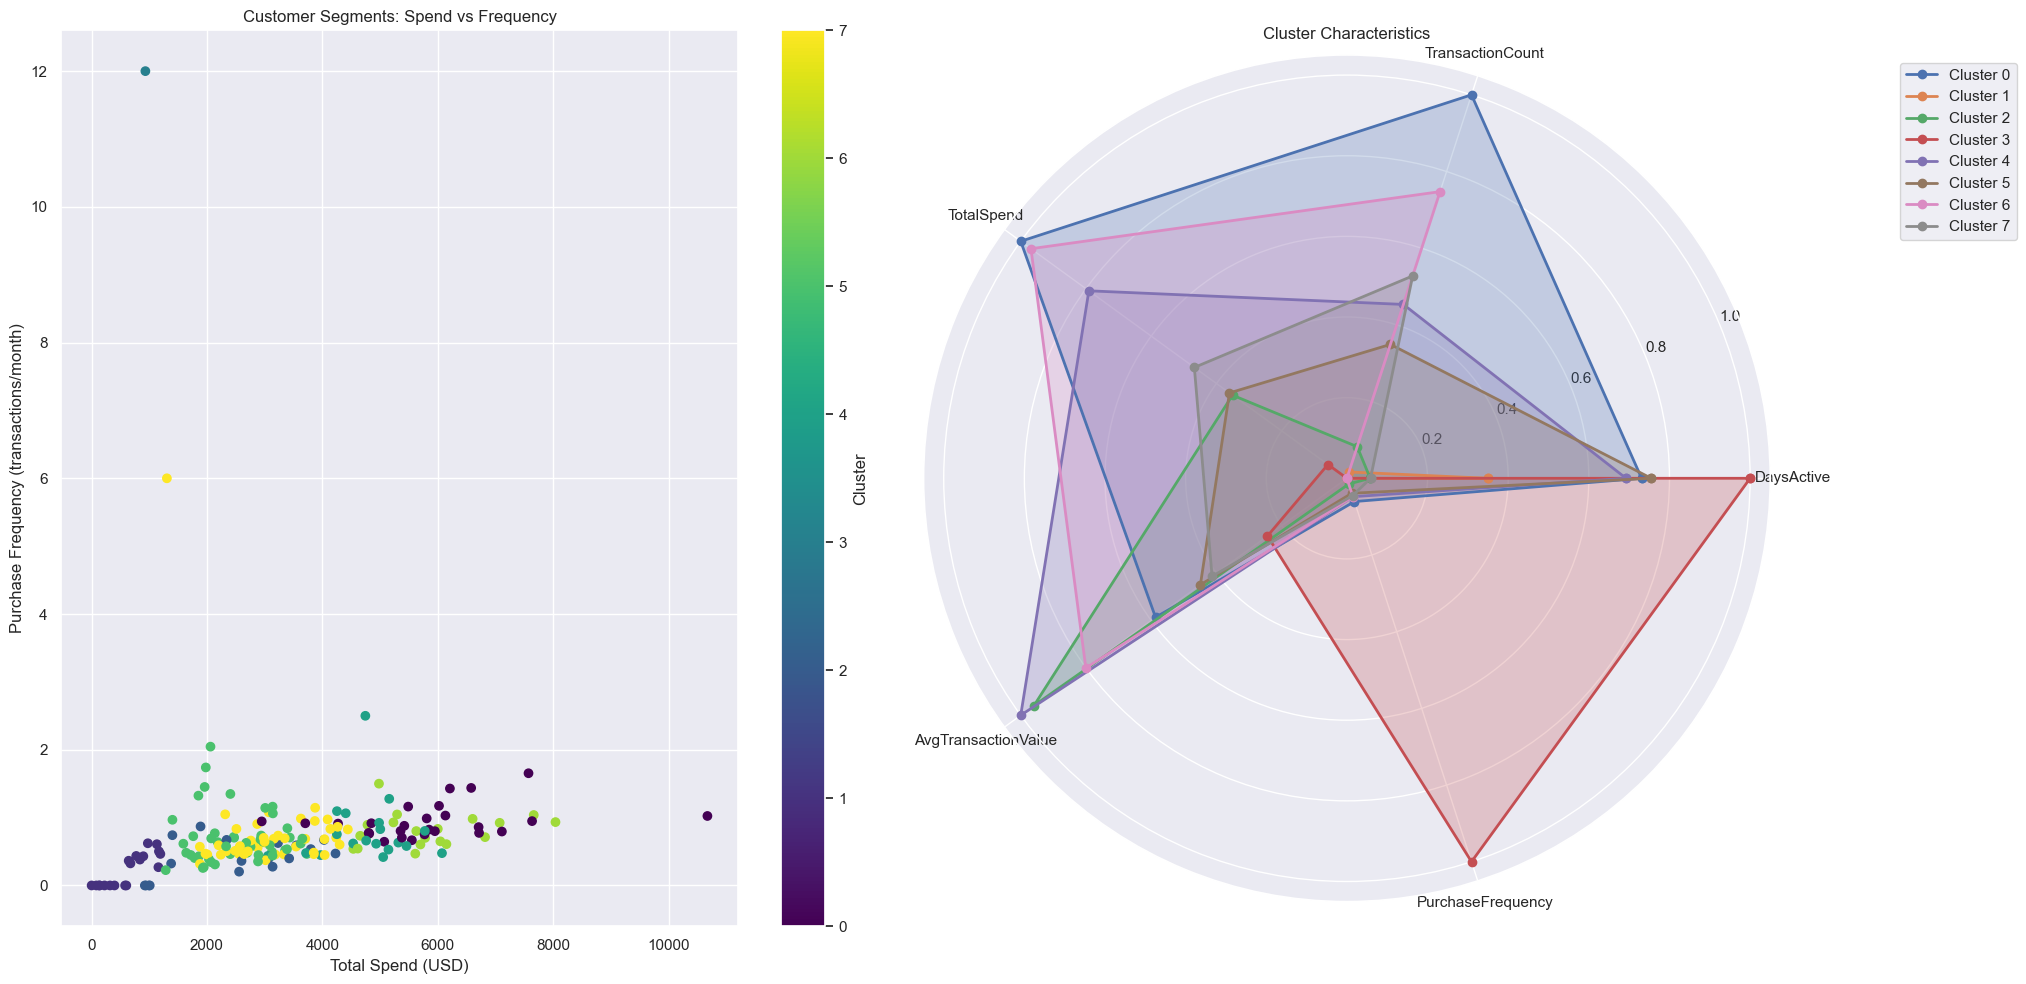

In [16]:
# Plot clustering visualizations
plot = plot_clusters(customer_data, features_to_cluster, customer_data['Cluster'])

### Evalutation

In [17]:
# Print evaluation metrics
print("Clustering Evaluation Metrics:")
print(f"- Optimal number of clusters: {optimal_k}")
print(f"- Davies-Bouldin Index (lower is better): {min(db_scores):.4f}")
print(f"- Silhouette Score (higher is better): {silhouette_scores[np.argmin(db_scores)]:.4f}\n")

# Generate cluster profiles
cluster_profiles = customer_data.groupby('Cluster').agg({
    'CustomerID': 'count',
    'TotalSpend': 'mean',
    'TransactionCount': 'mean',
    'PurchaseFrequency': 'mean',
    'AvgTransactionValue': 'mean'
}).round(2)

# Print cluster profiles
print("Cluster Profiles:")
for cluster_id, row in cluster_profiles.iterrows():
    print(f"\nCluster {cluster_id}:")
    print(f"- Number of Customers: {row['CustomerID']}")
    print(f"- Avg Total Spend: ${row['TotalSpend']}")
    print(f"- Avg Transaction Count: {row['TransactionCount']}")
    print(f"- Avg Purchase Frequency: {row['PurchaseFrequency']:.2f} transactions/month")
    print(f"- Avg Transaction Value: ${row['AvgTransactionValue']:.2f}")

Clustering Evaluation Metrics:
- Optimal number of clusters: 8
- Davies-Bouldin Index (lower is better): 0.9116
- Silhouette Score (higher is better): 0.2924

Cluster Profiles:

Cluster 0:
- Number of Customers: 26.0
- Avg Total Spend: $5861.11
- Avg Transaction Count: 8.38
- Avg Purchase Frequency: 0.95 transactions/month
- Avg Transaction Value: $706.65

Cluster 1:
- Number of Customers: 19.0
- Avg Total Spend: $627.26
- Avg Transaction Count: 2.11
- Avg Purchase Frequency: 0.23 transactions/month
- Avg Transaction Value: $295.05

Cluster 2:
- Number of Customers: 19.0
- Avg Total Spend: $2462.81
- Avg Transaction Count: 2.53
- Avg Purchase Frequency: 0.41 transactions/month
- Avg Transaction Value: $968.23

Cluster 3:
- Number of Customers: 1.0
- Avg Total Spend: $931.83
- Avg Transaction Count: 2.0
- Avg Purchase Frequency: 12.00 transactions/month
- Avg Transaction Value: $465.92

Cluster 4:
- Number of Customers: 19.0
- Avg Total Spend: $4767.65
- Avg Transaction Count: 4.89
- Av